# **<center>Practical Implementation </center>**


## <center> Solution Programming Session 4.2 - Time Series Forecasting - </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://hm-ai.github.io/ml-enpc/">
    <img src="https://drive.google.com/uc?export=view&id=12t-JTO4co2ZDxqdmNOOZG104izf5bSye" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1clLPEHUV6eAIw6di_L3-XTQRRmUfZg8Y?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>


---
## Position of the Problem

---



* Let us consider an entity $i$ at time $t$:

* We would like to predict the future values of the univariate time series $(y_i^{t})_{t-T_b+1 \leq t \leq t + T_f}$:
    * The past values in a $T_b$ sized window of the target times series: $(y_i^{t - T_b + 1}, \dots, y_i^{t})$
    * The future values up to the horizon $T_f$: $(y_i^{t + 1}, \dots, y_i^{t + T_f})$

* There are 3 possible inputs:


|        **Name**        |               **Description**                |                             **Introducting the notations of the features**                              | **Dimensionality** |
|:----------------------:|:--------------------------------------------:|:---------------------------------------------------------------------:|:------------------:|
|   Static attributes    |           Non sequential features            |                      $s_i \in \mathbb{R}^{d_s}$                       |       $d_s$        |
| Time varying unknown | Sequential features only know up to time $t$ | $(z_i^{t-T_b+1}, \dots,  z_i^{t}) \in \mathbb{R}^{T_b \times d_{z}} $ | $T_b \times d_{z}$ |
|  Time varying known   |    Sequential features know in the future    | $(x_i^{t+1}, \dots, x_i^{t+ T_f}) \in \mathbb{R}^{T_f \times d_{x}}$  | $T_f \times d_{x}$ |



* Let $\mathcal{Q}$ be the set of quantiles that interest us. For us, $\mathcal{Q} = \{0.1, 0.5, 0.9\}$.

* The model will output for each time step $t+ t_f$ for $t_f \in \{1, \dots, T_f\}$ the prediction associated with each quantile $q \in \mathcal{Q}$, denoted $\hat{y}_i^{t + t_f}(q)$

* Thus, for each $t_f \in \{1, \dots, T_f\}$, the output vector at each time step $t+ t_f$ is the following:

$$\hat{y}_i^{t + t_f} = \begin{bmatrix}
\vdots \\
\hat{y}_i^{t + t_f}(q)\\
\vdots\\
\end{bmatrix}_{q \in \mathcal{Q}}$$


<center><img width="800" src = "https://drive.google.com/uc?export=view&id=1XnsGEwXZDtzPHVKdUR6ew0r1ktEncwC6"></center>



---
## The Learning Problem
---

* In order to train the model, we compare the predictions $\hat{y}_i^{t + t_f} \in \mathbb{R}^{|\mathcal{Q}|}$ to the true value $y_i^{t + t_f}$ for all $t_f \in \{1, \dots, T_f\}$.

* The loss function can be written as follows:

$$
\mathcal{L} \left( \mathcal{B}, \theta \right) = \sum\limits_{i \in \mathcal{B}} \sum\limits_{q \in \mathcal{Q}} \sum\limits_{t_f = 1}^{T_f} \frac{QL_q \left(y_i^{t + t_f}, \hat{y}_i^{t + t_f}(q) \right)}{|\mathcal{B}| T_f}
$$

Where:

* $\mathcal{B}$ refers to the batch of training data.
* $\forall y, \hat{y} \in \mathbb{R} \quad QL_q(y, \hat{y}) = q(y - \hat{y})_+ + (1 -q) (\hat{y} - y)_+ = \max\left((q-1) (y - \hat{y}), q (y - \hat{y}) \right)$


----

---
# Introducing the Dataset

---
For this project, we utilize the **volatility dataset** provided by the Oxford-Man Institute of Quantitative Finance.The dataset spans from 2000 to the second quarter of 2022, capturing significant events, including the onset of the 2022 bear market.

### Dataset Overview

- **File**: `realized_volatility.csv`
- **Content**: Daily realized volatility values for 31 stock indices (e.g., SPX, FTSE), derived from intraday data, along with their daily returns.
- **Frequency**: Data is aggregated at a **daily** level.
- **Forecasting Horizon**: We predict the next week’s volatility (5 business days) using a rolling window of the past 7 weeks (35 data points).

### Dataset Columns

| **Column Name**   | **Description**                                                                 |
|--------------------|---------------------------------------------------------------------------------|
| `Symbol`          | Identifier for the index ticker.                                                |
| `rv5_ss`          | Realized volatility computed over 5-minute intervals with subsampling.          |
| `close_time`      | Timestamp indicating when the market closed for that observation.               |
| `rsv_ss`          | Realized semi-variance over intervals with subsampling applied.                 |
| `open_time`       | Timestamp indicating when the market opened for that observation.               |
| `rk_parzen`       | Realized kernel volatility using the Parzen kernel estimator.                   |
| `rv5`             | Realized volatility over 5-minute intervals without smoothing.                  |
| `rv10_ss`         | Realized volatility computed over 10-minute intervals with subsampling.         |
| `bv`              | Bipower variation, a measure of variation excluding jumps.                      |
| `close_price`     | Closing price of the index.                                                     |
| `rv10`            | Realized volatility over 10-minute intervals without smoothing.                 |
| `open_price`      | Opening price of the index.                                                     |
| `rk_twoscale`     | Realized kernel volatility using a two-scale estimator.                         |
| `medrv`           | Median realized volatility, a robust estimator that reduces sensitivity to outliers. |
| `bv_ss`           | Smoothed bipower variation.                                                     |
| `open_to_close`   | Measure of price movement from market open to close.                            |
| `nobs`            | Number of observations used to calculate realized measures.                     |
| `rsv`             | Realized variance.                                                              |
| `rk_th2`          | Realized kernel volatility.                                                     |


### The dataset

0. **Target Variable**:  
   Forecasting the log-transformed realized volatility: $\log(\text{rv5_ss})$.


1. **Static attributes**:  
   Grouping stock indices into geographic regions:
   - **EMEA** (Europe, Middle East, Africa)
   - **APAC** (Asia-Pacific)
   - **AMER** (Americas)

2. **Time-Varying Known features**:  
   We create additional features:
   - `days_from_start`: Number of days since the dataset’s start.
   - `day_of_week`: Day of the week (e.g., Monday).
   - `day_of_month`: Day of the month.
   - `week_of_year`: Week number within the year.

3. **Time-Varying Unknown features**:  
   - Feature: `open_to_close` (daily price movement from open to close).





In [57]:
# Install packages
!pip install neuralforecast
!pip install StatsForecast
!pip install hyperopt

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from neuralforecast.core import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.numpy import mae, mse

from functools import partial
from utilsforecast.losses import mae, mse,mase,smape
from utilsforecast.evaluation import evaluate

# Preprocess the dataset

This section focuses on preparing the Oxford-Man realized volatility dataset for time series forecasting. The goal is to enhance the dataset with additional temporal features, log-transform the realized volatility values for better model interpretability, and handle missing data to ensure consistency. The symbols are mapped to geographic regions to include static attributes in the analysis, and the data is formatted to comply with Nixtla's forecasting framework. This preprocessing step ensures that the data is clean, enriched, and ready for downstream modeling tasks.


---
<font color=green>Q1:</font>
<br><font color='green'>Write a Python function `preprocess_df` that preprocesses the realized volatility dataset. The function should:
- Load the dataset from the URL `'https://drive.google.com/uc?id=1ayOMVkA90imbW2bGozXDnAOK9o6SCHkL'`.
- Add temporal features like `days_from_start`, `day_of_week`, `day_of_month`, `week_of_year`, `month`, and `year`.
- Log-transform the `rv5_ss` column, replacing zeros with NaN before applying the transformation.
- Map financial symbols to geographic regions using a dictionary.
- Group the data by the `Symbol` column, forward-fill missing values in the `log_vol` column, and drop rows with remaining NaNs.
- Rename columns (`date` to `ds`, `Symbol` to `unique_id`, and `log_vol` to `y`) for compatibility with Nixtla.
</font>

---

In [59]:
def preprocess_df():
    """
    Preprocesses a dataset containing high-frequency realized volatility data.

    Objective:
        - Enhance the dataset with temporal features (e.g., days from start, day of the week).
        - Log-transform the realized volatility values.
        - Map stock indices to geographic regions.
        - Handle missing values by forward-filling and filtering incomplete rows.
        - Format the dataset for Nixtla's forecasting tools.

    Returns:
        pd.DataFrame: A cleaned and formatted DataFrame ready for time series analysis.
    """
    # Step 1: Load the dataset
    url = 'https://drive.google.com/uc?id=1ayOMVkA90imbW2bGozXDnAOK9o6SCHkL'
    df = pd.read_csv(url, index_col=0)

    # Step 2: Add temporal features
    idx = [str(s).split('+')[0] for s in df.index]
    dates = pd.to_datetime(idx)  # Convert cleaned date strings to pandas datetime objects

    df['date'] = dates
    df['days_from_start'] = (dates - datetime.datetime(2000, 1, 3)).days
    df['day_of_week'] = dates.dayofweek
    df['day_of_month'] = dates.day
    df['week_of_year'] = dates.isocalendar().week.tolist()
    df['month'] = dates.month
    df['year'] = dates.year
    df['categorical_id'] = df['Symbol'].copy()

    # Step 3: Log-transform realized volatility
    vol = df['rv5_ss'].copy()
    vol.loc[vol == 0.0] = np.nan  # Avoid log(0) by replacing zeros with NaN
    df['log_vol'] = np.log(vol)

    # Step 4: Map symbols to regions
    symbol_region_mapping = {
        '.AEX': 'EMEA', '.AORD': 'APAC', '.BFX': 'EMEA', '.BSESN': 'APAC', '.BVLG': 'EMEA',
        '.BVSP': 'AMER', '.DJI': 'AMER', '.FCHI': 'EMEA', '.FTMIB': 'EMEA', '.FTSE': 'EMEA',
        '.GDAXI': 'EMEA', '.GSPTSE': 'AMER', '.HSI': 'APAC', '.IBEX': 'EMEA', '.IXIC': 'AMER',
        '.KS11': 'APAC', '.KSE': 'APAC', '.MXX': 'AMER', '.N225': 'APAC', '.NSEI': 'APAC',
        '.OMXC20': 'EMEA', '.OMXHPI': 'EMEA', '.OMXSPI': 'EMEA', '.OSEAX': 'EMEA', '.RUT': 'EMEA',
        '.SMSI': 'EMEA', '.SPX': 'AMER', '.SSEC': 'APAC', '.SSMI': 'EMEA', '.STI': 'APAC',
        '.STOXX50E': 'EMEA'
    }
    df['Region'] = df['Symbol'].map(symbol_region_mapping)

    # Step 5: Clean and group data
    output_df_list = []
    for _, group in df.groupby('Symbol'):
        group = group.copy()
        group.sort_values('days_from_start', inplace=True)
        group['log_vol'] = group['log_vol'].ffill()
        group.dropna(inplace=True)
        output_df_list.append(group)

    df = pd.concat(output_df_list, axis=0)

    # Step 6: Format for Nixtla
    df = df.rename(columns={'date': 'ds', 'Symbol': 'unique_id', 'log_vol': 'y'})

    return df

# Preprocess the dataset
volatility_df = preprocess_df()

# View column names of the final dataset
volatility_df.columns

Index(['unique_id', 'rv5_ss', 'close_time', 'rsv_ss', 'open_time', 'rk_parzen',
       'rv5', 'rv10_ss', 'bv', 'close_price', 'rv10', 'open_price',
       'rk_twoscale', 'medrv', 'bv_ss', 'open_to_close', 'nobs', 'rsv',
       'rk_th2', 'ds', 'days_from_start', 'day_of_week', 'day_of_month',
       'week_of_year', 'month', 'year', 'categorical_id', 'y', 'Region'],
      dtype='object')

# Exploratory Data Analysis

This section demonstrates how to visualize the log volatility time series for each financial symbol in the dataset. By iterating over the `unique_id` column, the code generates individual plots for each stock index. These visualizations help analyze patterns, trends, and anomalies in the data over time. Proper labeling and formatting ensure the plots are clear and interpretable, making it easier to identify characteristics of each time series.


---
<font color=green>Q2:</font>
<br><font color='green'>Write a Python code snippet to visualize the time series data for each unique financial symbol in the `volatility_df` DataFrame. The code should:
- Iterate through all unique values in the `unique_id` column.
- For each symbol, filter the DataFrame to extract its time series.
- Plot the `ds` (date) on the x-axis and `y` (log volatility) on the y-axis.
- Add titles, axis labels, and ensure the x-axis ticks are rotated for better readability.
- Use appropriate figure dimensions (`15x4`) for clarity and ensure tight layouts for the plots.
</font>

---


In [60]:
# Iterate over each unique financial symbol in the dataset
for unique_id in volatility_df['unique_id'].unique():
    # Filter the DataFrame to extract data for the current symbol
    subset = volatility_df[volatility_df['unique_id'] == unique_id]

    # Create a new figure for the time series plot
    plt.figure(figsize=(15, 4))

    # Plot the time series: dates on the x-axis and log volatility on the y-axis
    plt.plot(subset['ds'], subset['y'], label=unique_id, color='blue')

    # Add a descriptive title for the plot, centered for readability
    plt.title(f'Time Series for {unique_id}', fontsize=16, loc='center')

    # Label the x-axis to indicate it represents dates
    plt.xlabel('Date', fontsize=12)

    # Label the y-axis to indicate it represents log volatility
    plt.ylabel('Log Volatility', fontsize=12)

    # Rotate x-axis ticks for better readability
    plt.xticks(rotation=45)

    # Adjust the layout to ensure no overlap of labels or elements
    plt.tight_layout()

    # Display the plot
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Training the Temporal Fusion Transformer

### **Objective**

The goal of this section is to train a Temporal Fusion Transformer (TFT) model for forecasting realized volatility. This involves preparing the data by splitting it into training and testing sets, extracting static and temporal features, and setting up the model for training. Cross-validation is then used to evaluate the model's performance over rolling windows, ensuring robust forecasting accuracy.

---
<font color=green>Q3:</font>
<br><font color='green'>Write a Python code snippet to reset the index of the `volatility_df` DataFrame and extract static features such as `Region` for each unique identifier. One-hot encode the `Region` column for use as static covariates.
</font>

---

In [61]:
# Reset the DataFrame index and prepare static features
df = volatility_df.reset_index(names='date_verbose')

# Extract static features (unique_id and Region), and one-hot encode the Region column
static_df = df[["unique_id", "Region"]].drop_duplicates().reset_index(drop=True)
static_df = pd.get_dummies(static_df, columns=['Region'])  # Create one-hot encoded static covariates

---
<font color=green>Q4:</font>
<br><font color='green'>Write a Python code snippet to split the dataset into training and testing sets:
- Training set: Data where the year is less than or equal to 2018.
- Testing set: Data where the year is greater than 2018, limiting each unique identifier to 750 rows.
</font>

---

In [62]:
df = df.loc[:, [
    'ds', 'unique_id', 'y', "open_to_close", "days_from_start",
    "day_of_week", "day_of_month", 'week_of_year', 'month', 'year'
]]

# Define the forecast horizon
horizon = 5  # Forecasting horizon of 5 days

# Training set: Include data from years up to 2018
train = df[df['year'] <= 2018]

# Testing set: Include data from years > 2018, limiting to 750 rows per unique_id
test = (
    df[df['year'] > 2018]
    .groupby('unique_id')[df.columns]  # Select all relevant columns
    .apply(lambda x: x.head(750))  # Limit to the first 750 rows for each unique_id
    .reset_index(drop=True)  # Reset index after grouping
)

---
<font color=green>Q5:</font>
<br><font color='green'>Write a Python code snippet to combine the training and testing sets into a single DataFrame.
</font>

---

In [63]:
# Combine training and testing sets
full_df = pd.concat([train, test])

# Validate the combined dataset length to ensure correctness
assert len(full_df) == len(train) + len(test), "Lengths do not match!"

---
<font color=green>Q6:</font>
<br><font color='green'>Write a Python code snippet to define and configure a Temporal Fusion Transformer model (`TFT`) with:
- A forecast horizon of 5 days.
- Input features including future and historical covariates.
- Static covariates obtained from the static DataFrame.
- Robust scaling and early stopping with validation checks every 10 steps.
</font>

---

In [64]:
# Define and configure the Temporal Fusion Transformer model
models = [
    TFT(
        h=horizon,  # Forecasting horizon
        input_size=7 * horizon,  # Historical input size (7 weeks)
        futr_exog_list=['day_of_week', 'day_of_month', 'week_of_year'],  # Future covariates
        hist_exog_list=['open_to_close'],  # Historical covariates
        stat_exog_list=list(static_df.columns[1:]),  # Static covariates (one-hot encoded regions)
        max_steps=1000,  # Maximum number of training steps
        val_check_steps=10,  # Check validation metrics every 10 steps
        early_stop_patience_steps=10,  # Stop early if no improvement for 10 validation checks
        scaler_type='robust',  # Use robust scaling for data normalization
    ),
]

INFO:lightning_fabric.utilities.seed:Seed set to 1


---
<font color=green>Q7:</font>
<br><font color='green'>Write a Python code snippet to perform cross-validation using the Temporal Fusion Transformer model. Ensure the validation size is 100 rows, the test size is 750 rows, and the step size matches the forecast horizon.</font>

---

In [65]:
# Initialize NeuralForecast with the configured models
nf = NeuralForecast(models=models, freq='D')  # Daily frequency for the dataset

# Perform cross-validation to evaluate the model
nf_predictions = nf.cross_validation(
    full_df,
    val_size=100,  # Validation window size
    test_size=750,  # Testing window size
    n_windows=None,  # Number of rolling windows (None = use the entire dataset)
    step_size=horizon,  # Step size for each rolling window
    static_df=static_df  # Static features for each unique_id
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 2.0 K  | train
4 | static_encoder          | StaticCovariateEncoder   | 548 K  | train
5 | temporal_encoder        | TemporalCovariateEncoder | 1.0 M  | train
6 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
7 | output_adapter          | Linear                   | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [66]:
nf_predictions

,unique_id,ds,cutoff,TFT,y
0,.AEX,2019-01-02,2018-12-31,-9.616542,-7.947064
1,.AEX,2019-01-03,2018-12-31,-9.579586,-9.289448
2,.AEX,2019-01-04,2018-12-31,-9.563648,-9.228208
3,.AEX,2019-01-07,2018-12-31,-9.646977,-9.439407
4,.AEX,2019-01-08,2018-12-31,-9.594707,-9.663385
...,...,...,...,...,...
23245,.STOXX50E,2021-12-22,2021-12-21,-9.151438,-10.373855
23246,.STOXX50E,2021-12-23,2021-12-21,-9.116037,-10.843207
23247,.STOXX50E,2021-12-24,2021-12-21,-9.175198,-12.936914
23248,.STOXX50E,2021-12-27,2021-12-21,-9.589108,-10.699889


# Evaluating Temporal Fusion Transformer

### **Objective**

This section evaluates the performance of the trained Temporal Fusion Transformer (TFT) model using various metrics. The evaluation includes calculating commonly used error metrics like SMAPE, MAE, MSE, and MASE (with seasonality). These metrics provide insights into the accuracy and reliability of the model's forecasts.


---
<font color=green>Q8:</font>
<br><font color='green'>Write a Python code snippet to calculate the evaluation metrics (SMAPE, MAE, MSE, and MASE with seasonality) for the TFT model predictions. Use a seasonality value of 5 for the MASE metric.
</font>

---

In [67]:
# Define seasonality for the MASE metric
seasonality = 5
mase_seas = partial(mase, seasonality=seasonality)  # Create a partial function for MASE with fixed seasonality

# Evaluate the model predictions
evaluation_tft = evaluate(
    df=nf_predictions.reset_index(),  # Use the predictions DataFrame
    metrics=[smape, mae, mse, mase_seas],  # List of metrics to evaluate
    train_df=train,  # Pass the training DataFrame for reference
    models=['TFT']  # Specify the model name for evaluation
)
evaluation_tft

,unique_id,metric,TFT
0,.AEX,smape,0.027308
1,.AORD,smape,0.027455
2,.BFX,smape,0.025138
3,.BSESN,smape,0.025493
4,.BVLG,smape,0.018467
...,...,...,...
119,.SPX,mase,1.028807
120,.SSEC,mase,0.715099
121,.SSMI,mase,0.910879
122,.STI,mase,0.804947


---
<font color=green>Q9:</font>
<br><font color='green'>Write a Python code snippet to identify numeric columns in the evaluation DataFrame and pivot the data to aggregate the metrics by their mean values. Display the aggregated evaluation metrics for the Temporal Fusion Transformer in a table.
</font>

---

In [68]:
# Identify numeric columns in the evaluation DataFrame
numeric_cols = evaluation_tft.select_dtypes(include='number').columns

# Pivot the evaluation DataFrame to calculate the mean for each metric
evaluation_tft_df = evaluation_tft.pivot_table(
    index='metric',  # Use 'metric' as the row index
    values=numeric_cols,  # Aggregate numeric columns
    aggfunc='mean'  # Compute the mean for each metric
)

# Reset the index for a clean presentation
evaluation_tft_df.reset_index(inplace=True)
# Display the final evaluation table
evaluation_tft_df

,metric,TFT
0,mae,0.492081
1,mase,0.843764
2,mse,0.427134
3,smape,0.025410


# Plotting TFT Forecasts

### **Objective**

This section demonstrates how to visualize the predictions made by the Temporal Fusion Transformer (TFT) model. The function `plot_timeseries` generates multi-plot visualizations that compare past data, predicted values, and observed test values for specified items.

---
<font color=green>Q10:</font>
<br><font color='green'>Write a Python function `plot_timeseries` to plot time series data for specified item IDs. The function should:
- Display past time series data, forecasted values, and observed values.
- Optionally include out-of-sample predictions and confidence intervals.
</font>

---

In [69]:
def plot_timeseries(Y_train_df, predictions, item_ids_to_plot, model_name, intervals, train_index, pred_index, out_of_sample):
    """
    Plots time series data including past, predicted, and observed values for specified item IDs.

    Parameters:
    - Y_train_df (DataFrame): The training dataset containing historical time series data.
    - predictions (DataFrame): DataFrame containing predictions for specified item IDs.
    - item_ids_to_plot (list): List of item IDs for which the time series plots will be generated.
    - model_name (str): Name of the model used for forecasting.
    - intervals (bool): Flag indicating whether to include confidence intervals in the plot.
    - train_index (int): Index for context-length.
       * If negative, it displays the last train_index datapoints.
       * If zero, they are skipped altogether.
    - pred_index (int): Index for prediction data.
       * If negative, the last train_index datapoints from the test set are displayed.
       * If positive, the first train_index datapoints from the test set are displayed.
    - out_of_sample (DataFrame or None): DataFrame containing out-of-sample predictions (optional).

    Returns:
    - None

    Description:
    This function generates a multi-plot visualization for each specified item in `item_ids_to_plot`,
    showing the past time series, forecasted values, observed values, and optionally, out-of-sample predictions.
    """
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    plt.figure(figsize=(13, 2 * len(item_ids_to_plot)))

    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(len(item_ids_to_plot), 1, i + 1)

        y_past = Y_train_df.set_index(['unique_id', 'ds']).loc[item_id]['y']
        y_pred = predictions.loc[item_id]
        y_test = predictions.loc[item_id]['y']

        y_past = y_past[train_index:] if train_index < 0 else y_past[:0]
        y_pred = y_pred[pred_index:] if pred_index < 0 else y_pred[:pred_index]
        y_test = y_test[pred_index:] if pred_index < 0 else y_test[:pred_index]

        plt.plot(y_past, label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred[model_name], label="Forecast", color=colors[1], linestyle='-')

        if out_of_sample is not None and not out_of_sample.empty:
            y_out_of_sample = out_of_sample.loc[item_id]
            plt.plot(y_out_of_sample[model_name], label="Out-of-Sample", color=colors[4], linestyle='-')

        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')
        if intervals:
            plt.fill_between(
                y_pred.index, y_pred[model_name + "-lo-80"], y_pred[model_name + "-hi-80"],
                color=colors[1], alpha=0.1, label="10%-90% Test Confidence Interval"
            )

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

---
<font color=green>Q11:</font>
<br><font color='green'>Use the `plot_timeseries` function to visualize the predictions of the Temporal Fusion Transformer (TFT) model for all unique items in the dataset? Ensure the last 100 data points of the training set are displayed along with the first 759 prediction data points.
</font>

---

In [70]:
# Set the index for predictions
nf_predictions = nf_predictions.set_index(['unique_id', 'ds'])

# Call the plot_timeseries function
plot_timeseries(
    Y_train_df=train,  # Training dataset
    predictions=nf_predictions,  # Predictions DataFrame
    item_ids_to_plot=list(df['unique_id'].unique()),  # List of all unique item IDs
    model_name="TFT",  # Model name
    intervals=False,  # Do not include confidence intervals
    train_index=-100,  # Display the last 100 training data points
    pred_index=759,  # Display the first 759 prediction points
    out_of_sample=None  # No out-of-sample predictions provided
)

Output hidden; open in https://colab.research.google.com to view.

# Temporal Fusion Transformer Interpretability


### **Objective**

This section demonstrates how to interpret the Temporal Fusion Transformer (TFT) model using its attention mechanisms and feature importance metrics. The goal is to understand which features and time points the model focuses on for forecasting. This involves visualizing attention weights, analyzing static and temporal feature importance.

### Attention Weights

---
<font color=green>Q12:</font>
<br><font color='green'>Retrieve and visualize the attention weights of the Temporal Fusion Transformer (TFT) model to understand its focus during forecasting?
</font>

---

(40, 40)


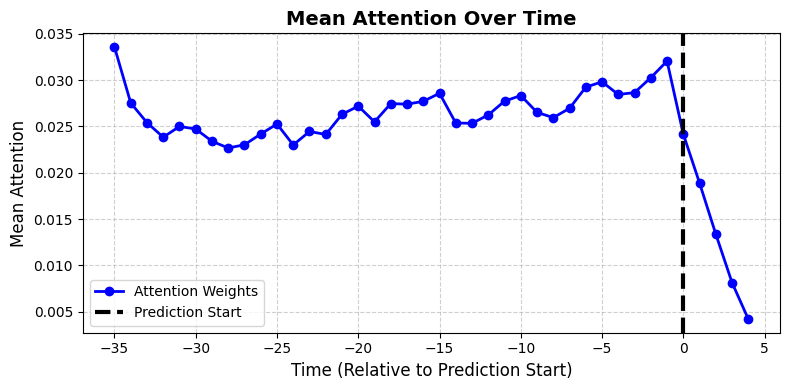

In [71]:
# Retrieve attention weights from the model
attention = nf.models[0].attention_weights()
print(attention.shape)
attention

# Define input size for analysis
input_size = nf.models[0].input_size

# Prepare a visualization for attention weights
fig, ax = plt.subplots(figsize=(8, 4))

# Focus on the attention from the input size onward and compute mean across rows
attention = attention[input_size:, :].mean(axis=0)
x_values = np.arange(-input_size, horizon)

ax.plot(x_values, attention, label="Attention Weights", color="blue", linewidth=2, marker='o')
ax.axvline(x=0, color='black', linewidth=3, linestyle='--', label="Prediction Start")
ax.set_title("Mean Attention Over Time", fontsize=14, fontweight='bold')
ax.set_xlabel("Time (Relative to Prediction Start)", fontsize=12)
ax.set_ylabel("Mean Attention", fontsize=12)

# Add legend and grid for clarity
ax.legend(loc="best", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()

# Display the attention plot
plt.show()

### Feature Importances

---
<font color=green>Q13:</font>
<br><font color='green'>Extract and explore the feature importance metrics of the Temporal Fusion Transformer model?
</font>

---

In [72]:
# Retrieve feature importance metrics
feature_importances = nf.models[0].feature_importances()
feature_importances.keys()

dict_keys(['Past variable importance over time', 'Future variable importance over time', 'Static covariates'])

In [73]:
# Display the Past variable importance over time
df = feature_importances['Static covariates']
df

,importance
Region_EMEA,0.061581
Region_AMER,0.230411
Region_APAC,0.708008


In [74]:
# Display the Past variable importance over time
df = feature_importances['Past variable importance over time']
df

,open_to_close,day_of_week,day_of_month,week_of_year,observed_target
0,0.232317,0.027652,0.068540,0.237934,0.433557
1,0.228802,0.027669,0.068904,0.234525,0.440100
2,0.228945,0.027863,0.068620,0.236813,0.437760
3,0.228886,0.027526,0.068036,0.234188,0.441365
4,0.229921,0.027550,0.068459,0.239989,0.434081
5,0.232149,0.027343,0.067016,0.239789,0.433703
6,0.227465,0.027465,0.067274,0.236456,0.441340
7,0.226986,0.027617,0.067204,0.238763,0.439429
8,0.227081,0.027327,0.066563,0.235088,0.443941
9,0.227855,0.027313,0.066781,0.241101,0.436951


In [75]:
# Display the future variable importance over time
df = feature_importances['Future variable importance over time']
df

,day_of_week,day_of_month,week_of_year
0,0.080618,0.484260,0.435121
1,0.081566,0.479360,0.439074
2,0.083281,0.476359,0.440361
3,0.084043,0.445823,0.470134
4,0.084400,0.467387,0.448212


---
<font color=green>Q14:</font>
<br><font color='green'>Write a Python code snippet to visualize feature importance across static, past, and future variables using a bar plot.
</font>

---

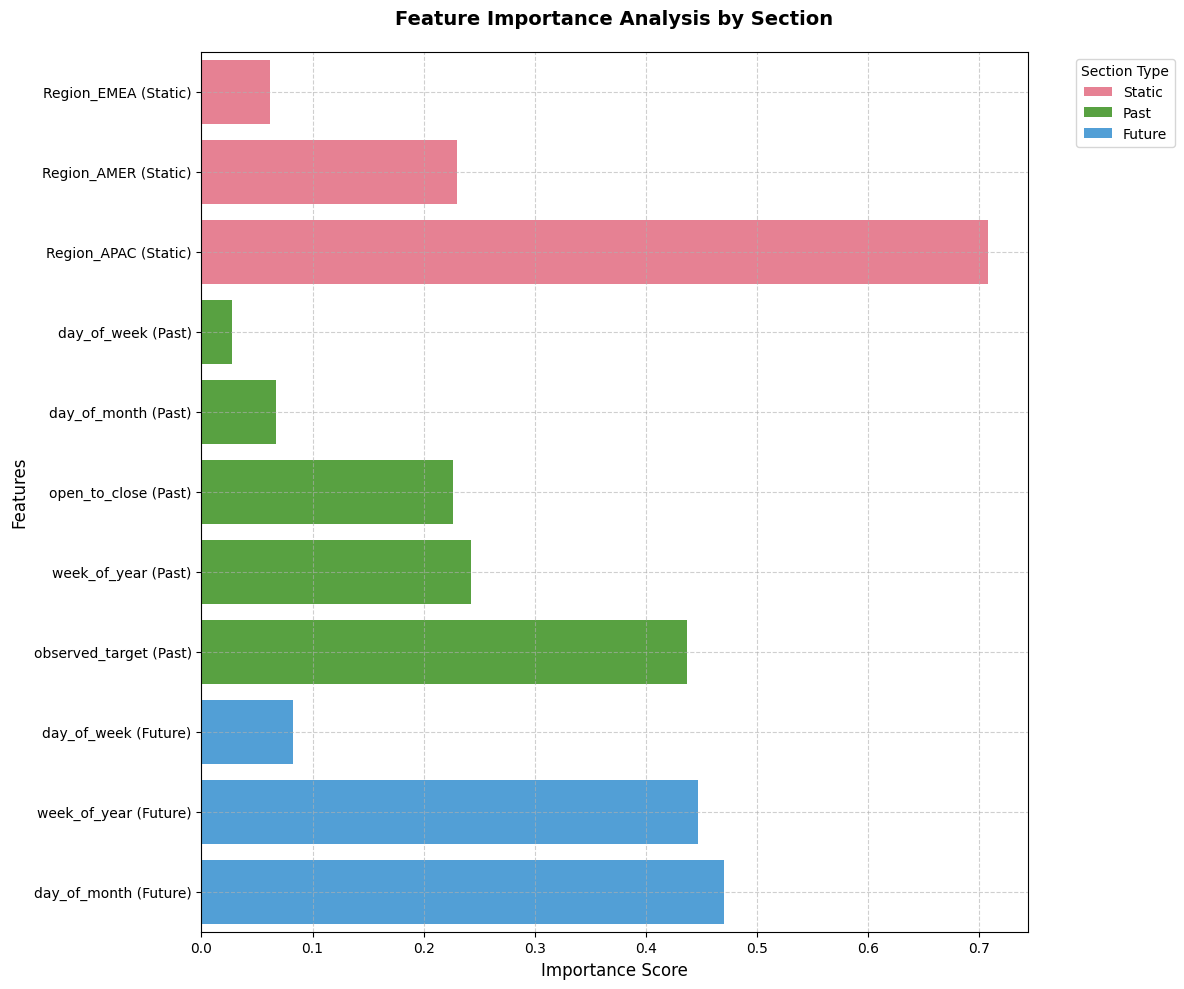

In [76]:
# Static feature importance
static_importance = (
    feature_importances['Static covariates']
    .sort_values(by='importance')
    .assign(section='Static')
    .reset_index()
    .rename(columns={'index': 'variable'})
)

# Past feature importance
past_importance = (
    feature_importances['Past variable importance over time']
    .mean()
    .sort_values()
    .reset_index()
    .assign(section='Past')
    .rename(columns={'index': 'variable', 0: 'importance'})
)

# Future feature importance
future_importance = (
    feature_importances['Future variable importance over time']
    .mean()
    .sort_values()
    .reset_index()
    .assign(section='Future')
    .rename(columns={'index': 'variable', 0: 'importance'})
)

# Combine all feature importance data
combined_df = pd.concat([static_importance, past_importance, future_importance])

# Create a unique identifier for each (variable, section) pair
combined_df['unique_label'] = combined_df['variable'] + ' (' + combined_df['section'] + ')'

# Create a bar plot for feature importance
plt.figure(figsize=(12, 10))
colors = sns.color_palette("husl", 3)
ax = sns.barplot(
    data=combined_df,
    y='unique_label',
    x='importance',
    hue='section',
    palette=colors,
    dodge=False
)

# Add plot title and axis labels
plt.title('Feature Importance Analysis by Section',
          pad=20,
          fontsize=14,
          fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Configure legend and grid
plt.legend(title='Section Type',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the bar plot
plt.show()

### Contact

If you have any question regarding this notebook, do not hesitate to contact: hachem.madmoun@gmail.com